# Customer Behaviour Insight Engine – Notebook 6c  
## CBS Integration – Device Mix Comparison

### Goal of this notebook

Integrate **external Dutch statistics (CBS)** with the synthetic e-commerce dataset used in this project.

Concretely:

- Load the **cleaned CBS digital adoption table** (`cbs_digital_clean.csv`) with:
  - `year`
  - `device_category` (e.g. `mobile_total`, `smartphone`, `tablet`)
  - `share_pct` (percentage of Dutch population 12+ using that device type)

- Load the **site session data** (`sessions_enriched.csv`) and:
  - Calculate the **device mix** of sessions (`desktop`, `mobile`, `tablet`)
  - Derive site-level metrics comparable to CBS (e.g. “any mobile device”, “smartphone”, “tablet”)

- Build a **comparison table**:
  - CBS device usage (2019, NL population) vs.
  - Site device usage (share of sessions)

- Visualise these differences in a simple bar chart.

- Export the comparison as a **SQL-ready table** that can be loaded into a data warehouse or BI tool.

In [17]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)
pd.set_option("display.float_format", "{:.2f}".format)

### 1. Load cleaned CBS data and site sessions

Use:

- `../data/processed/cbs_digital_clean.csv` → tidy CBS device usage (from Notebook 6b)  
- `../data/processed/sessions_enriched.csv` → session-level data with a `device` column

Then calculate device shares on the site and compare them to CBS.

In [18]:
processed_path = "../data/processed/"

cbs_devices = pd.read_csv(processed_path + "cbs_digital_clean.csv")

print("CBS devices shape:", cbs_devices.shape)
display(cbs_devices.head())

sessions_enriched = pd.read_csv(processed_path + "sessions_enriched.csv")

print("'nSessions enriched shape:", sessions_enriched.shape)
print("Columns:", sessions_enriched.columns.tolist())

print("\nDevice value counts:")
print(sessions_enriched["device"].value_counts(dropna=False))

CBS devices shape: (40, 3)


,year,device_category,share_pct
0,2012,mobile_total,51.40
1,2013,mobile_total,60.70
2,2014,mobile_total,65.90
3,2015,mobile_total,71.10
4,2016,mobile_total,73.20


'nSessions enriched shape: (120000, 17)
Columns: ['session_id', 'customer_id', 'start_time', 'device', 'source', 'country', 'session_start', 'session_end', 'session_duration_min', 'n_events', 'n_page_views', 'n_add_to_cart', 'n_checkout', 'n_purchase', 'total_qty', 'session_revenue', 'made_purchase']

Device value counts:
device
mobile     65942
desktop    45547
tablet      8511
Name: count, dtype: int64


## 2. Site device mix (sessions by device)

To:

- Count how many sessions use each device 
- Convert that into percentages of all sessions 
- Create a small, clean table that can be compared to CBS data.

In [19]:
# 2.1 Count sessions per device 
device_counts = (
    sessions_enriched
    .groupby("device")["session_id"]
    .nunique()
    .reset_index(name="n_sessions")
    .sort_values("n_sessions", ascending=False)
    
    )

total_sessions = device_counts["n_sessions"].sum()
device_counts["share_pct"] = (device_counts["n_sessions"] / total_sessions * 100).round(1)

print("Site device counts and shares:")
device_counts 

Site device counts and shares:


,device,n_sessions,share_pct
1,mobile,65942,55.00
0,desktop,45547,38.00
2,tablet,8511,7.10


## 3. Align site metrics with CBS device categories 

The CBS data has: 

- `mobile_total`, - "any mobile device"
- `smarptphone`
- `tablet`
- `other_mobile`

My site has (from the value counts above:)

- `desktop`
- `mobile`
- `tablet`
- (possibly other minor catgories)

To make them comparable: 

**From the stie data**

- `site_mobile_total_pct` = `% of sessions on mobile OR tablet`
- `site_smartphone_pct` = `% or sessions on mobile`
- `site_tablet_pct` = `% of sessions on tablet`

`laptop` and `other_mobile` is ignored site-side becuase the Kaggle dataset doesn't distinguish them as separate devices.

In [20]:
# Helper to safely get percentage for a device label
site_share_by_device = (
    device_counts.set_index("device")["share_pct"].to_dict()
)

site_mobile_pct = site_share_by_device.get("mobile", 0.0)
site_tablet_pct = site_share_by_device.get("tablet", 0.0)

# Total "mobile" usage on site = mobile + tablet
site_mobile_total_pct = round(site_mobile_pct + site_tablet_pct)

print("Derived site metrcs:")
print("site_mobile_total_pct:", site_mobile_total_pct)
print("site_smartphone_pct:", site_mobile_total_pct)
print("site_tablet_pct:", site_tablet_pct)

Derived site metrcs:
site_mobile_total_pct: 62
site_smartphone_pct: 62
site_tablet_pct: 7.1


## 4. Choose a CBS reference year 

The CBS data covers 2012-2019.
The synthetic e-commerce data is not tied to a specific real year, but to keep things realistic: 

- Use **2019** as the reference year (latest available in this table)
- Interpret that as "roughly current" device usage in the Netherlands

In [21]:
cbs_2019_df = cbs_devices[cbs_devices["year"] == 2019].copy()
cbs_2019_df

,year,device_category,share_pct
7,2019,mobile_total,84.40
15,2019,smartphone,82.50
23,2019,laptop,35.00
31,2019,tablet,27.50
39,2019,other_mobile,10.90


In [22]:
cbs_2019_pivot = (
    cbs_2019_df
    .set_index("device_category")["share_pct"]
    .to_dict()
)

cbs_2019_pivot

{'mobile_total': 84.4,
 'smartphone': 82.5,
 'laptop': 35.0,
 'tablet': 27.5,
 'other_mobile': 10.9}

## 5. Build CBS vs Site comparison table 

Focus is on device types that can be reasonably matched: 

- `mobile_total`
- `smartphone`
- `tablet`

For each include: 

- `cbs_pct` - % of Dutch population (12+) using internet on that device type
- `site_pct` - % of sessions on that device type (or combination)

In [27]:
device_compare = pd.DataFrame([
    {
        "Device Category": "Any mobile device",
        "CBS (2019)": cbs_2019_pivot["mobile_total"],
        "Site (%)": site_mobile_total_pct,
        "Interpretation": "Broad mobile usage: smartphone + tablet on site vs CBS 'any mobile'."
    },
    {
        "Device Category": "Smartphone",
        "CBS (2019)": cbs_2019_pivot["smartphone"],
        "Site (%)": site_mobile_pct,
        "Interpretation": "Site 'mobile' traffic approximates smartphone usage."
    },
    {
        "Device Category": "Tablet",
        "CBS (2019)": cbs_2019_pivot["tablet"],
        "Site (%)": site_tablet_pct,
        "Interpretation": "Direct tablet-to-tablet comparison."
    },
])

device_compare["Difference (Site - CBS)"] = (
    device_compare["Site (%)"] - device_compare["CBS (2019)"]
).round(1)

device_compare

,Device Category,CBS (2019),Site (%),Interpretation,Difference (Site - CBS)
0,Any mobile device,84.40,62.00,Broad mobile usage: smartphone + tablet on sit...,-22.40
1,Smartphone,82.50,55.00,Site 'mobile' traffic approximates smartphone ...,-27.50
2,Tablet,27.50,7.10,Direct tablet-to-tablet comparison.,-20.40


### Interpretation Summary

Compared to Dutch national behaviour in 2019: 

-**Smartphone usage on the site is significationlt lower (55% vs 82.5%)**, suggesting the site is not fully optimized for mobile-first usage patterns typical in the Netherlands.
- **Tablet usage is much loer on the site (7.1% vs 27.5%)**, possibly indicating either device incompatibility or product type difference. 
-**Overall mobile usage (mobile + tablet) is lower on the site (62% vs 84.4%)**, suggestiing an opportunity to improve mobile experience and capture more mobile traffic.

### 6. Visualize CBS vs Site device mix 

Create a simple bar chart to show: 

- For each metric (mobile_total, smartphone, tablet)
- CBS percentage vs Site percentage 

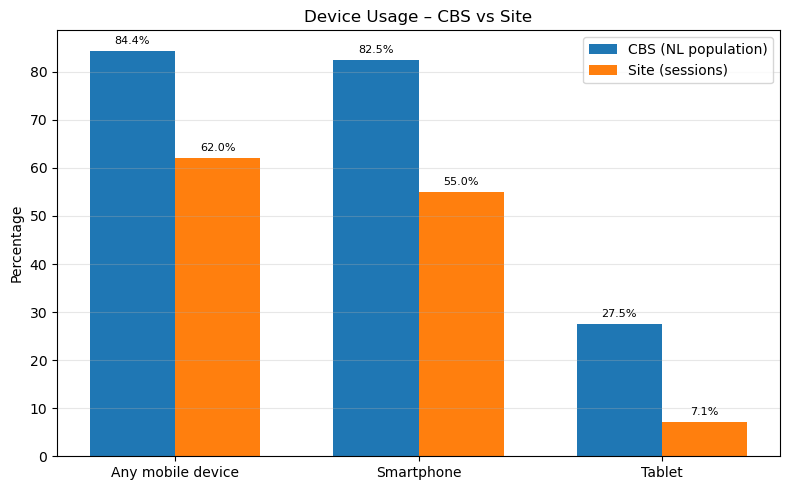

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# --- Basic setup ---
x_labels = device_compare["Device Category"]
cbs_values = device_compare["CBS (2019)"]
site_values = device_compare["Site (%)"]

x = np.arange(len(device_compare))
width = 0.35

plt.figure(figsize=(8, 5))

bars_cbs = plt.bar(x - width/2, cbs_values,  width, label="CBS (NL population)")
bars_site = plt.bar(x + width/2, site_values, width, label="Site (sessions)")

plt.xticks(x, x_labels, rotation=0)
plt.ylabel("Percentage")
plt.title("Device Usage – CBS vs Site")
plt.legend()
plt.grid(axis="y", alpha=0.3)

# --- Optional: add value labels above bars ---
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 1,
            f"{height:.1f}%",
            ha="center",
            va="bottom",
            fontsize=8,
        )

add_labels(bars_cbs)
add_labels(bars_site)

plt.tight_layout()
plt.show()

# 6.1 Possible Extensions 

This notebook focuses on one concrete integration: device mix on the site vs CBS national statistics. 

To extend this project, logical next steps would be:

- **Hour-of-day behaviour vs CBS internet useage times**
    Use a CBS dataset with internet usage by time-of-day and compare it to my 
    session start-hour distribution from `sessions_enriched`.

 - **Average Order Value (AOV) vs Dutch household spending**
    Bring in a CBS dataset on household consumption or e-commerce spend and
    benchmark my AOV against Dutch averages. 

- **Additional SQL-ready tables**
    Export the CBS-enriched metrics (e.g. device comparison table) as 
    `cbs_device_compare` for downstream use in dashboards or BI tools. 





### 7. Export SQL-ready comparison table

To make this integration reusable in dashboards or further analysis, export the CBS vs site device comparions as a flat table that can be loaded in SQL or a BI tool.

The output table contains: 

- `year` (CBS reference year)
- `device_category` (e.g. Any mobile device, Smartphone, Tablet)
- `cbs_pct` (CBS share in %)
- `site_pct` (site share in % of sessions)
- `difference_site_minus_cbs`
- `interpretation` (short notes)

Easy to join with other fact tables or use in visualisations.

In [33]:
# 7. Export SQL-ready comparison table

# Start from the comparison DataFrame we already built
device_compare_sql = device_compare.copy()

# Add metadata columns for easier use in SQL / BI
device_compare_sql["year"] = 2019
device_compare_sql.rename(
    columns={
        "Device Category": "device_category",
        "CBS (2019)": "cbs_pct",
        "Site (%)": "site_pct",
        "Difference (Site - CBS)": "difference_site_minus_cbs",
        "Interpretation": "interpretation",
    },
    inplace=True,
)

# Reorder columns into a simple, SQL-friendly schema
device_compare_sql = device_compare_sql[
    [
        "year",
        "device_category",
        "cbs_pct",
        "site_pct",
        "difference_site_minus_cbs",
        "interpretation",
    ]
]

# Save to processed folder
out_path = processed_path + "cbs_device_compare.csv"
device_compare_sql.to_csv(out_path, index=False)

print(f"Saved SQL-ready device comparison to: {out_path}")
device_compare_sql.head()

Saved SQL-ready device comparison to: ../data/processed/cbs_device_compare.csv


,year,device_category,cbs_pct,site_pct,difference_site_minus_cbs,interpretation
0,2019,Any mobile device,84.40,62.00,-22.40,Broad mobile usage: smartphone + tablet on sit...
1,2019,Smartphone,82.50,55.00,-27.50,Site 'mobile' traffic approximates smartphone ...
2,2019,Tablet,27.50,7.10,-20.40,Direct tablet-to-tablet comparison.


### 8. Summary 

This notebook integrates Dutch CBS device-usage statistics with the site’s session data to create a market benchmark.
Because the Kaggle dataset represents a global e-commerce site, and CBS reflects Dutch national behaviour, the comparison highlights how the site would perform if targeting the Netherlands.

Key insights:
	•	Overall mobile usage is lower on the site (62% vs 84.4% in NL).
	•	Smartphone usage is much lower (55% vs 82.5%).
	•	Tablet usage is also far below Dutch levels (7.1% vs 27.5%).

Taken as a regional benchmark, this suggests that a global site expanding into the Dutch market would need a stronger mobile-first experience, as Dutch users rely far more on smartphones and tablets.

Output:
A clean SQL-ready comparison table (cbs_device_compare.csv) and a bar chart visualising CBS vs site device mix.
